In [1]:
import numpy as np
from osgeo import gdal, osr
import rasterio as rio
import torch

In [3]:
dataset_dem = gdal.Open('../scripts/test_dem.tif')
dataset_photo = gdal.Open('../scripts/test_ortho.tif')
# composite_photo = gdal.Open('BhaginatoKajra_CompositeBand.tif')
print(dataset_dem.RasterCount)
print(dataset_photo.RasterCount)
# print(composite_photo.RasterCount)

dem_prj = dataset_dem.GetProjection()
photo_prj = dataset_photo.GetProjection()
print(dem_prj)
print(photo_prj)

srs=osr.SpatialReference(wkt=dem_prj)
if srs.IsProjected:
    print (srs.GetAttrValue('projcs'))
print (srs.GetAttrValue('geogcs'))

srs=osr.SpatialReference(wkt=photo_prj)
if srs.IsProjected:
    print (srs.GetAttrValue('projcs'))
print (srs.GetAttrValue('geogcs'))

band1 = dataset_dem.GetRasterBand(1)
print(band1)


1
4
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
None
WGS 84
None
WGS 84
<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x111c81b00> >


In [4]:
SLICE_SIZE = 512
MM_TO_PIXEL = 3   #3mm is represented by one pixel
# Varies depending on the orthophoto


In [5]:
my_dem_array = np.array(dataset_dem.ReadAsArray())
my_ortho_array = np.array(dataset_photo.ReadAsArray())
# my_composite_array = np.array(composite_photo.ReadAsArray())
print(my_dem_array.shape)
print(my_ortho_array.shape)
# print(my_composite_array.shape)

#change shape to 3 dimension for ortho
my_ortho_array = my_ortho_array[0:3, :, :]
print(my_ortho_array.shape)


(16598, 12309)
(4, 33073, 24324)
(3, 33073, 24324)


In [6]:
image2d = my_ortho_array[0]
print(image2d.shape)


(33073, 24324)


In [7]:
geotransform1 = dataset_photo.GetGeoTransform()
geotransform2 = dataset_dem.GetGeoTransform()

x_pixel = 10000
y_pixel = 10000

x_coord1 = geotransform1[0] + (x_pixel * geotransform1[1]) + (y_pixel * geotransform1[2])
y_coord1 = geotransform1[3] + (x_pixel * geotransform1[4]) + (y_pixel * geotransform1[5])


x_coord2 = geotransform2[0] + (x_pixel * geotransform2[1]) + (y_pixel * geotransform2[2])
y_coord2 = geotransform2[3] + (x_pixel * geotransform2[4]) + (y_pixel * geotransform2[5])

print(x_coord1, y_coord1)
print(x_coord2, y_coord2)

75.67716012794149 28.36118112340073
75.67756054280572 28.360825314200916


In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import patches
import cv2

def show_image(image, bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    
    for box in bboxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((y_min, x_max), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.savefig("test.png")

def show_image_2(image):

    r, g, b = image[0], image[1], image[2]
    rgb_image = np.stack([r, g, b], axis=-1)
    plt.imshow(rgb_image)
    plt.savefig("test1.png")


In [9]:
def check_garbage_slice(image, xmin, ymin, xmax, ymax):
    
    corner1 = image[:, xmin-1, ymin-1]
    corner2 = image[:, xmin-1, ymax-1]
    corner3 = image[:, xmax-1, ymin-1]
    corner4 = image[:, xmax-1, ymax-1]
    reject = [255, 255, 255]
    corners = [corner1, corner2, corner3, corner4]

    for corner in corners:
        if (corner == reject).all():
            return True

    return False

def calculate_slice_bboxes(
    image,
    image_height: int,
    image_width: int,
    slice_height: int = SLICE_SIZE,
    slice_width: int = SLICE_SIZE,
    overlap_height_ratio: float = 0.2,
    overlap_width_ratio: float = 0.2,
) -> list[list[int]]:
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.
    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """
    print(image.shape)
    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = int(overlap_height_ratio * slice_height)
    x_overlap = int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                if not check_garbage_slice(image, xmin, ymin, xmax, ymax):
                    slice_bboxes.append([xmin, ymin, xmax, ymax])

            else:
                if not check_garbage_slice(image, x_min, y_min, x_max, y_max):
                    slice_bboxes.append([x_min, y_min, x_max, y_max])

            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
        
    return slice_bboxes


In [10]:
width = my_ortho_array.shape[1] 
height = my_ortho_array.shape[2]
print(height, width)
slices = calculate_slice_bboxes(image=my_ortho_array, image_height=height, image_width=width)
print(len(slices))

print(my_ortho_array[:, 33072, 24323])
print(my_ortho_array[:, 9122, 2460])

print(slices[:10])

24324 33073
(3, 33073, 24324)
4860
[255 255 255]
[103 124  93]
[[0, 0, 512, 512], [410, 0, 922, 512], [820, 0, 1332, 512], [1230, 0, 1742, 512], [1640, 0, 2152, 512], [2050, 0, 2562, 512], [2460, 0, 2972, 512], [2870, 0, 3382, 512], [3280, 0, 3792, 512], [3690, 0, 4202, 512]]


(33073, 24324)


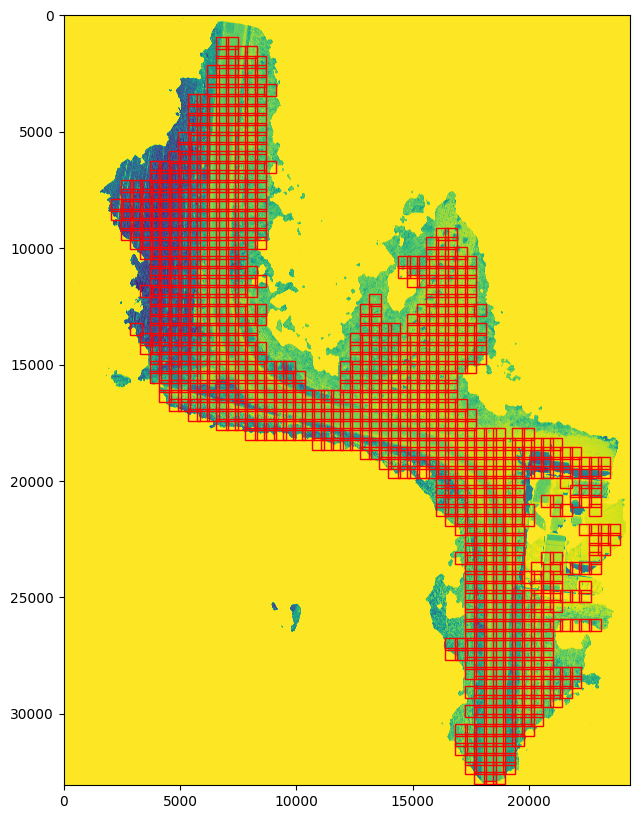

In [9]:
# for slice_idx, slice_box in enumerate(slices):
#     show_image(image2d, [slice_box], [''])

# show_image(myarray, bboxes=slices, class_labels=[''])
print(image2d.shape)

show_image(image2d, slices)
# show_img_cv2(image2d, slices)



In [27]:
slice_index = 1000
xmin, ymin, xmax, ymax = slices[slice_index]
# show_image(myarray[:, ymin:ymax, xmin:xmax,])
print(xmin, ymin, xmax, ymax)
print(my_ortho_array.shape)

# NOTE: x and y are interchanged when showing the images
sliced_image = my_ortho_array[:, xmin:xmax, ymin:ymax]

print(sliced_image.shape)
print(sliced_image)
show_image_2(sliced_image)



28700 19680 29212 20192
(3, 33073, 24324)
(3, 512, 512)
[[[196 195 191 ... 204 195 203]
  [199 200 199 ... 206 195 205]
  [202 204 203 ... 200 188 198]
  ...
  [195 204 214 ... 193 199 207]
  [207 212 215 ... 200 207 218]
  [209 206 203 ... 204 209 218]]

 [[183 180 176 ... 197 188 197]
  [185 185 184 ... 202 187 195]
  [189 188 187 ... 197 179 188]
  ...
  [189 196 207 ... 179 185 192]
  [198 204 208 ... 186 194 204]
  [200 197 197 ... 191 197 206]]

 [[155 155 152 ... 161 152 161]
  [158 159 157 ... 163 150 162]
  [160 160 159 ... 160 144 156]
  ...
  [152 164 172 ... 148 153 160]
  [165 168 177 ... 153 161 171]
  [168 159 168 ... 156 161 170]]]


In [28]:
# model = torch.load('best.pt')
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', source='github')

# print(model)

Using cache found in /Users/adityadandwate/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-25 Python-3.11.0 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7031701 parameters, 0 gradients
Adding AutoShape... 


In [36]:
from PIL import Image

# img = Image.open("long_crack1.jpeg")

result = model(sliced_image)
result.show()
print(result.xyxyn[0])


tensor([[0.42334, 0.02478, 0.60411, 0.97720, 0.38600, 0.00000]])


In [32]:
def get_bbox_coords(result, image_dim):

    boxes = result.xyxyn[0]
    if len(boxes) == 0:
        return
    print(boxes)
    for box in boxes:
        box = np.array(box)
        print(box)
        xmin, ymin, xmax, ymax, confidence, label = box
        print("before scaling: ", xmin, ymin, xmax, ymax)
        xmin *= image_dim
        xmax *= image_dim
        ymin *= image_dim
        ymax *= image_dim

        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        print("after scaling: ", xmin, ymin, xmax, ymax)
    return xmin, ymin, xmax, ymax



In [35]:
if get_bbox_coords(result, SLICE_SIZE) is not None:
    xmin_rel, ymin_rel, xmax_rel, ymax_rel = get_bbox_coords(result, SLICE_SIZE) 

    # These are the absolute pixel coordinates of bbox wrt the original orthophoto
    xmin_rel += xmin
    ymin_rel += ymin
    xmax_rel += xmin
    ymax_rel += ymin

    print("bbox coords wrt complete image: ", (xmin_rel, ymin_rel), (xmax_rel, ymax_rel))

    # The coordinates of those pixels on the real world
    geotransform = dataset_photo.GetGeoTransform()

    x_min_real = geotransform[0] + xmin_rel * geotransform[1] + ymin_rel * geotransform[2]
    y_min_real = geotransform[3] + xmin_rel * geotransform[4] + ymin_rel * geotransform[5]

    x_max_real = geotransform[0] + xmax_rel * geotransform[1] + ymax_rel * geotransform[2]
    y_max_real = geotransform[3] + xmax_rel * geotransform[4] + ymax_rel * geotransform[5]

    print("coords: ", (x_min_real, y_min_real), (x_max_real, y_max_real))
else:
    print("No detection here")



No detection here


In [154]:
# use real word coords on the geotagged orthophoto
geotransform_dem = dataset_dem.GetGeoTransform()

print(my_dem_array.shape)

# Create a spatial reference system object from the dataset
srs = osr.SpatialReference()
srs.ImportFromWkt(dataset_dem.GetProjection())

# Create a coordinate transformation object
coord_transform = osr.CoordinateTransformation(srs, srs.CloneGeogCS())

# Convert the real-world coordinates to projected coordinates
x_proj_min, y_proj_min, _ = coord_transform.TransformPoint(x_min_real, y_min_real)
x_proj_max, y_proj_max, _ = coord_transform.TransformPoint(x_max_real, y_max_real)

# Apply the geotransformation to obtain pixel coordinates
x_min_dem = int((x_proj_min - geotransform_dem[0]) / geotransform_dem[1])
y_min_dem = int((y_proj_min - geotransform_dem[3]) / geotransform_dem[5])

x_max_dem = int((x_proj_max - geotransform_dem[0]) / geotransform_dem[1])
y_max_dem = int((y_proj_max - geotransform_dem[3]) / geotransform_dem[5])

# Print the pixel coordinates

print("image pixel coords: ", (x_min_dem, y_min_dem), (x_max_dem, y_max_dem))

(16598, 12309)
image pixel coords:  (3437, 1350) (3474, 1479)


In [162]:
from tqdm import tqdm

# iterating through all the slices
final_bboxes = []

def get_check_bbox_coords(result, image_dim, slice):
    
    xmin_slice, ymin_slice, xmax_slice, ymax_slice = slice

    boxes = result.xyxyn[0]
    for box in boxes:
        box = np.array(box)
        # print(box)
        xmin, ymin, xmax, ymax, confidence, label = box

        if label == 7:          # index label of the pothole in the in the model

            print("Found!")
            print("before scaling: ", xmin, ymin, xmax, ymax)
            xmin *= image_dim
            xmax *= image_dim
            ymin *= image_dim
            ymax *= image_dim

            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
            print("after scaling: ", xmin, ymin, xmax, ymax)

            # Get coordinates wrt original orthophoto
            xmin += xmin_slice
            ymin += ymin_slice
            xmax += xmax_slice
            ymax += xmax_slice

            bbox = (xmin, ymin, xmax, ymax)
            final_bboxes.append(bbox)

        else:
            continue 

for slice in tqdm(slices):
    xmin, ymin, xmax, ymax = slice
    sliced_image = my_ortho_array[:, xmin:xmax, ymin:ymax]
    result = model(sliced_image)
    get_check_bbox_coords(result, sliced_image.shape[0], slice)       # adds the bbox coordinates to the list wrt orthophoto

    # Note: The object detector doesn't work very well and there are not many potholes in general so
    # there is a high likelyhood the list will be empty. Moreover the label
    # index may have to be changed

 63%|██████▎   | 698/1112 [08:31<05:03,  1.36it/s]


KeyboardInterrupt: 

In [37]:
# Now the final_bboxes list contains all the bboxes in the formant [min, max] where min is top-left and max is top-right

# Now convert the final bbox coords wrt to the ones on the DEM

def coord_converter(xmin_photo, ymin_photo, xmax_photo, ymax_photo):

    # Get geotransform of the orthophoto
    geotransform_photo = dataset_photo.GetGeoTransform()

    # Get the real world coordinates
    x_min_real = geotransform[0] + xmin_photo * geotransform[1] + ymin_photo * geotransform[2]
    y_min_real = geotransform[3] + xmin_photo * geotransform[4] + ymin_photo * geotransform[5]

    x_max_real = geotransform[0] + xmax_photo * geotransform[1] + ymax_photo * geotransform[2]
    y_max_real = geotransform[3] + xmax_photo * geotransform[4] + ymax_photo * geotransform[5]

    # use real word coords on the geotagged orthophoto
    geotransform_dem = dataset_dem.GetGeoTransform()

    srs = osr.SpatialReference()
    srs.ImportFromWkt(dataset_dem.GetProjection())

    coord_transform = osr.CoordinateTransformation(srs, srs.CloneGeogCS())

    # Convert the real-world coordinates to projected coordinates
    x_proj_min, y_proj_min, _ = coord_transform.TransformPoint(x_min_real, y_min_real)
    x_proj_max, y_proj_max, _ = coord_transform.TransformPoint(x_max_real, y_max_real)

    # Apply the geotransformation to obtain pixel coordinates
    x_min_dem = int((x_proj_min - geotransform_dem[0]) / geotransform_dem[1])
    y_min_dem = int((y_proj_min - geotransform_dem[3]) / geotransform_dem[5])

    x_max_dem = int((x_proj_max - geotransform_dem[0]) / geotransform_dem[1])
    y_max_dem = int((y_proj_max - geotransform_dem[3]) / geotransform_dem[5])

    # Note the last two items are the real world coordinates of the centroid of the bbox to identify and locate each pothole
    return x_min_dem, y_min_dem, x_max_dem, y_max_dem, (x_min_real + x_max_real)/2, (y_min_real + y_max_real)/2

def convert_coords_to_dem(final_bboxes):

    final_bboxes_dem = []

    for box in final_bboxes:

        final_box_dem = coord_converter(box[0], box[1], box[2], box[3])
        final_bboxes_dem.append(final_box_dem)
    return final_bboxes_dem

In [39]:
# Calculate the volume of the pothole

def calculate_volume_and_maxdepth(final_bboxes_dem):

    volume_max_depth = []
    for box in final_bboxes_dem:

        x_min_dem, y_min_dem, x_max_dem, y_max_dem, x_real, y_real = box
        sliced_dem = my_dem_array[x_min_dem:x_max_dem, y_min_dem:y_max_dem]

        max_depth = np.max(sliced_dem)
        min_depth = np.min(sliced_dem)

        # We shall use our min depth as the floor depth
        volume = 0
        for i in range(SLICE_SIZE):
            for j in range(SLICE_SIZE):
                
                area = MM_TO_PIXEL*MM_TO_PIXEL
                depth_wrt_floor = my_dem_array[i][j] - min_depth
                volume += area*depth_wrt_floor
        
        volume_max_depth.append(volume, max_depth - min_depth, (x_real, y_real))  # contains the volume, the max depth, and the real world coords of the potholes

    return volume_max_depth
        

In [40]:
final_bboxes_dem = convert_coords_to_dem(final_bboxes)

# We now use these bboxes coords wrt dem to work on the dem
# Each pothole will be identified by a key which will be its exact coordinate

# Will contain the volume of the pothole along with the max depth and the real world coords
volume_max_depth = calculate_volume_and_maxdepth(final_bboxes_dem)


NameError: name 'final_bboxes' is not defined

In [42]:
severity_dict = {0: 'SMALL', 1: 'MEDIUM', 2: 'LARGE'}

# Use the final bbox dims as well as the max depth and volume to give the final result
# Use the severity dict to get the labels
def calculate_severity(volume_max_depth):
    
    final_results = []
    # using final bboxes and final bboxes dem for consistency across the mm to pixel ratio
    for i, box in enumerate(final_bboxes):

        xmin, ymin, xmax, ymax = box
        xlength = xmax - xmin
        ylength = ymax - ymin

        xlength *= MM_TO_PIXEL
        ylength *= MM_TO_PIXEL

        width = max(xlength, ylength)

        volume, depth, real_coords = volume_max_depth[i]

        # depth value is in metres so convert to mm
        depth *= 1000

        # Severity is either small or medium
        if width >= 500:
            if depth >= 25 and depth <= 50:
                """
                Contains:
                Volume, Severity Label, real world coordinates
                """
                final_results.append(volume, 1, real_coords)

            elif depth > 50:
                final_results.append(volume, 2, real_coords)
            else:
                final_results.append(volume, 1, real_coords)        # Classify as medium in undefined edge case
            
        else:
            final_results.append(volume, 0, real_coords)    # Classify as small in all undefined edge cases in this category
        
    return final_results

    


SMALL
